# Energy Consumption Imputation (ELECTRICITY)

In this notebook, <br>
<b>1)</b> we developed machine learning models based on matched PUMS data (el_training.csv created from the R script) The model training results are saved in el_training_model_comparisons.csv file. <br>
<b>2)</b> We applied the best model to unmatched records (el_imputing.csv created from the R script). The imputed results are saved in el_imputed.csv<br>

## Import python packages

In [1]:
import numpy as np
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor, BaggingRegressor, ExtraTreesRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.linear_model import Ridge, LinearRegression,ElasticNet,Lasso
from sklearn.cross_validation import cross_val_score, cross_val_predict
from sklearn.metrics import mean_absolute_error, explained_variance_score, r2_score, median_absolute_error
from sklearn.utils import check_array
from sklearn import preprocessing
from sklearn.neighbors import NearestNeighbors
from sklearn import preprocessing
from sklearn.cross_validation import KFold, LeaveOneOut, ShuffleSplit,train_test_split
from sklearn.base import clone
from sklearn.svm import LinearSVR
from sklearn.neural_network import MLPRegressor
import csv
import matplotlib.pyplot as plt
plt.style.use('seaborn-paper')
import pandas as pd
import time
from IPython.display import HTML,display
def show(html):
    display(HTML(html))

/usr/local/lib/python3.5/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d
/usr/local/lib/python3.5/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [ ]:
## Input files identification

In [2]:
energy_source = "el" # energy source "el" - electricity; "ng" - natural gas; "o" - other

energy = "BTU" + energy_source.upper()
fn = "output/" + energy_source + "_training.csv"
test_fn= "output/" + energy_source + "_imputing.csv"

imputed_output_fn = "output/" + energy_source +"_imputed.csv"
out_fn = "output/" + energy_source + "_training_model_comparisons.csv"

## Data processing

In [6]:

original_mateched = pd.read_csv(fn)
X = pd.read_csv(fn)
# exclude columns that are irrelevant to energy consumption
exclude_names = ["SERIALNO", "RT", "DIVISION","PUMA","REGION","ST","ADJHSG","ADJINC","WGTP"] 
X.drop(exclude_names, inplace= True, axis = 1)
column_names = list(X)

f_cat_count = 0
f_con_count = 0
percentNAN = []
print("Index\tName\t%15s\t%15s"%("Mean", "Std. Dev."))
for i,name in enumerate(column_names):
    
    if name[-1] != "P" and name != energy:
        X[name] = X[name].astype('category') # variables with names not ending with "P" are categorical
        f_cat_count += 1 
        missingVals = pd.isnull(X[name])
        percentNAN.append([name,sum(missingVals)/float(X.shape[0])])

    elif name != energy:
        missingVals = pd.isnull(X[name])
        percentNAN.append([name,sum(missingVals)/float(X.shape[0])])
        col_mean = X[name].mean()
        col_std = X[name].std()
        X[name] = X[name].astype('float')
        f_con_count += 1
        print("%i\t%s\t%15.2f\t%15.2f"%(f_con_count, name, col_mean, col_std))
    elif name == energy:
        X[name] = X[name].astype('float')


droppedFeatures = []
for i, item in enumerate(percentNAN):
    name = item[0]
    percentMissing = item[1]
    if percentMissing > 0.1: # drop varialbes that has more than 10% missing values
        if name[-1] == "P":
            f_con_count -= 1
        else:
            f_cat_count -= 1
        X = X.drop(name,1)
        droppedFeatures.append(name)


X = pd.get_dummies(X) # convert categorical variables into dummies


Y = X[energy]
X = X.drop(energy,1)
observation, features = X.shape
print("-"*70)
print("number of observation: %d \nnumber of features: %d \nnumber of continuous variables: %d\nnumber of categorical variables: %d\nnumber of features dropped due to missing values: %d" % (observation, features, f_con_count, f_cat_count, len(droppedFeatures)))
print("-"*70)
print( "Dropped Features")
print( "-"*70)
print( droppedFeatures)

Index	Name	           Mean	      Std. Dev.
1	NP	           2.23	           1.26
2	BDSP	           2.74	           1.10
3	CONP	           7.73	          63.52
4	DIALUP	           1.51	           0.85
5	ELEP	         116.92	          68.08
6	FIBEROP	           1.42	           0.84
7	FULP	         373.02	         827.67
8	GASP	          56.41	          83.40
9	INSP	         556.31	         674.91
10	LAPTOP	           1.22	           0.42
11	MHP	          63.76	         505.48
12	MRGP	         391.95	         639.94
13	RMSP	           6.19	           2.34
14	RNTP	         195.31	         389.31
15	SMP	          28.49	         138.48
16	VALP	      142866.60	      197572.45
17	WATP	         381.32	         493.14
18	FFINCP	           0.21	           0.41
19	FGRNTP	           0.05	           0.22
20	FHINCP	           0.32	           0.47
21	FINCP	       54086.77	       72990.91
22	FPLMPRP	           0.00	           0.00
23	FSMOCP	           0.22	           0.41
24	GRNTP	         232.46	      

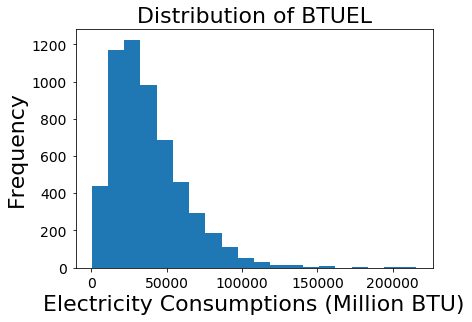

In [7]:
fig, ax = plt.subplots(1,1,figsize=(6.4,4.4))
plt.hist(Y, 20)

ax.set_title("Distribution of BTUEL", fontsize=22, color='k')
ax.set_ylabel("Frequency", fontsize=22, color='k')
ax.set_xlabel("Electricity Consumptions (Million BTU)", fontsize=22, color='k')
ax.tick_params(axis='both', which='major', labelsize=14)

plt.show()
plt.close()

## Regressor and metrics set up 

In [14]:
# Average percent difference
def averagePercentDifference(predictions, actual): 
    assert len(predictions) == len(actual)
    return np.mean(np.abs(predictions - actual)/actual) * 100

regressors = [
    Ridge(),
#     LinearRegression(),
    ElasticNet(),
    Lasso(),
    AdaBoostRegressor(),
    BaggingRegressor(),
    GradientBoostingRegressor(max_depth=4, n_estimators=20, verbose=1),
    RandomForestRegressor(max_depth=3, n_estimators= 60, n_jobs=-1, verbose=0),
    ExtraTreesRegressor(max_depth=3, n_jobs=-1, verbose=0),
    MLPRegressor()
]

regressorNames = [
    "Ridge Regressor",
#     "Linear Regressor",
    "ElasticNet",
    "Lasso",
    "AdaBoost Regressor",
    "Bagging Regressor",
    "Gradient Boosting Regressor, 4_20",
    "Random Forest Regressor",
    "Extra Trees Regressor",
    "MLPRegressor"
]

assert len(regressors) == len(regressorNames)

metrics = [
    mean_absolute_error,
    median_absolute_error,
    r2_score,
    averagePercentDifference
]

metricNames = [
    "Mean Absolute Error",
    "Median Absolute Error",
    "$r^2$",
    "Mean Average Percent Difference"
]

assert len(metrics) == len(metricNames)

## Run experiements

In [15]:

numberOfExperiments = 10
numberOfSamples = X.shape[0]
startTime = float(time.time())

bestMetric = metrics[0] # metric which we use to save the best regressor 
bestMetricScores = [float('inf') for _ in range(len(regressors))]
bestRegressorModels = [None for _ in range(len(regressors))]
bestRegressorNames = regressorNames
bestMetricScoresList = [[] for _ in range(len(regressors))]

results = [] # [k][i][j] is the results on the the jth metric for the ith regressor in the kth experiment run

crossValidatorIterator = ShuffleSplit(n=numberOfSamples, n_iter=numberOfExperiments, test_size=0.25, train_size=None, random_state=None)

for i, (train_index, test_index) in enumerate(crossValidatorIterator):
    print("Running experiment %d out of %d" % (i+1, numberOfExperiments))
    
    regressorScores = [] # [i][j] is the jth metric result for the ith regressor
    X_train, X_test = X.loc[train_index,], X.loc[test_index,]
    y_train, y_test = Y.loc[train_index,], Y.loc[test_index,]

    for j, (regressor,regressorName) in enumerate(zip(regressors,regressorNames)):
        print("\tTraining %s" % (regressorName))
        regressor = clone(regressor)
        
        regressor.fit(X_train,y_train)
        predicted = regressor.predict(X_test)
        predicted[predicted<0] = 0 # if prediction smaller than 0 convert to 0
        
        scores = []
        for metric in metrics:
            score = metric(y_test,predicted)
            scores.append(score)
        
        #Record best trained model
        score = bestMetric(y_test,predicted)
        if score < bestMetricScores[j]:
            bestMetricScores[j] = score
            bestRegressorModels[j] = regressor
            bestMetricScoresList[j] = scores
            
        regressorScores.append(scores)
                
    results.append(regressorScores)

results = np.array(results)

Running experiment 1 out of 10
	Training Ridge Regressor
	Training ElasticNet
	Training Lasso


/usr/local/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


	Training AdaBoost Regressor
	Training Bagging Regressor
	Training Gradient Boosting Regressor, 4_20
      Iter       Train Loss   Remaining Time 
         1   488482783.6081            0.91s
         2   418220687.6483            0.86s
         3   361308268.3931            0.82s
         4   314939736.7158            0.77s
         5   277271022.0188            0.72s
         6   245841972.6998            0.67s
         7   220014885.9216            0.62s
         8   199289777.2000            0.58s
         9   181938238.0860            0.53s
        10   167865287.1612            0.48s
        20   110168540.8492            0.00s
	Training Random Forest Regressor
	Training Extra Trees Regressor
	Training MLPRegressor
Running experiment 2 out of 10
	Training Ridge Regressor
	Training ElasticNet


/usr/local/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


	Training Lasso


/usr/local/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


	Training AdaBoost Regressor
	Training Bagging Regressor
	Training Gradient Boosting Regressor, 4_20
      Iter       Train Loss   Remaining Time 
         1   481559506.5351            0.92s
         2   413370528.4795            0.87s
         3   358104774.1655            0.82s
         4   313209404.4515            0.78s
         5   275856100.0822            0.72s
         6   246176155.4855            0.68s
         7   221372916.5392            0.62s
         8   201469145.4839            0.58s
         9   184957551.4417            0.53s
        10   171624910.1790            0.48s
        20   116360208.9018            0.00s
	Training Random Forest Regressor
	Training Extra Trees Regressor
	Training MLPRegressor
Running experiment 3 out of 10
	Training Ridge Regressor
	Training ElasticNet


/usr/local/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


	Training Lasso


/usr/local/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


	Training AdaBoost Regressor
	Training Bagging Regressor
	Training Gradient Boosting Regressor, 4_20
      Iter       Train Loss   Remaining Time 
         1   469997285.7221            0.95s
         2   403457611.7501            0.89s
         3   349726736.2427            0.83s
         4   305705447.9647            0.79s
         5   269397152.4546            0.74s
         6   240246518.4546            0.69s
         7   216512699.4313            0.64s
         8   196674508.5615            0.59s
         9   180796592.2335            0.54s
        10   167630788.3439            0.49s
        20   113600394.3521            0.00s
	Training Random Forest Regressor
	Training Extra Trees Regressor
	Training MLPRegressor
Running experiment 4 out of 10
	Training Ridge Regressor
	Training ElasticNet
	Training Lasso


/usr/local/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


	Training AdaBoost Regressor
	Training Bagging Regressor
	Training Gradient Boosting Regressor, 4_20
      Iter       Train Loss   Remaining Time 
         1   508119104.0559            0.94s
         2   435568251.3959            0.88s
         3   376639217.2021            0.83s
         4   328856142.0742            0.78s
         5   289695337.1379            0.73s
         6   257738495.9104            0.68s
         7   231842248.0007            0.63s
         8   210515948.2600            0.59s
         9   193329791.1481            0.54s
        10   178815916.9572            0.48s
        20   120273748.3928            0.00s
	Training Random Forest Regressor
	Training Extra Trees Regressor
	Training MLPRegressor
Running experiment 5 out of 10
	Training Ridge Regressor
	Training ElasticNet
	Training Lasso


/usr/local/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


	Training AdaBoost Regressor
	Training Bagging Regressor
	Training Gradient Boosting Regressor, 4_20
      Iter       Train Loss   Remaining Time 
         1   483873125.0663            0.94s
         2   415022686.9333            0.89s
         3   359131454.0512            0.84s
         4   313820705.2078            0.79s
         5   276874938.8870            0.75s
         6   246320141.2048            0.69s
         7   221837618.5642            0.65s
         8   201785899.6784            0.60s
         9   184978068.4502            0.55s
        10   171521113.4664            0.50s
        20   114931248.9599            0.00s
	Training Random Forest Regressor
	Training Extra Trees Regressor
	Training MLPRegressor
Running experiment 6 out of 10
	Training Ridge Regressor
	Training ElasticNet
	Training Lasso


/usr/local/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


	Training AdaBoost Regressor
	Training Bagging Regressor
	Training Gradient Boosting Regressor, 4_20
      Iter       Train Loss   Remaining Time 
         1   486400898.3559            0.94s
         2   417060648.2435            0.88s
         3   360817273.2685            0.83s
         4   315149355.3051            0.78s
         5   278067429.9739            0.73s
         6   247294075.1642            0.68s
         7   222636459.9741            0.63s
         8   202125703.7849            0.59s
         9   185766468.1525            0.54s
        10   172270396.1471            0.49s
        20   116156698.1461            0.00s
	Training Random Forest Regressor
	Training Extra Trees Regressor
	Training MLPRegressor
Running experiment 7 out of 10
	Training Ridge Regressor
	Training ElasticNet
	Training Lasso


/usr/local/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


	Training AdaBoost Regressor
	Training Bagging Regressor
	Training Gradient Boosting Regressor, 4_20
      Iter       Train Loss   Remaining Time 
         1   511422744.4391            0.94s
         2   438908933.1219            0.87s
         3   380228154.6262            0.83s
         4   332344459.4562            0.78s
         5   293525343.0749            0.73s
         6   261406737.3721            0.68s
         7   235600313.1218            0.63s
         8   214190962.7408            0.58s
         9   196400334.0348            0.53s
        10   182157498.5266            0.48s
        20   122545763.2413            0.00s
	Training Random Forest Regressor
	Training Extra Trees Regressor
	Training MLPRegressor
Running experiment 8 out of 10
	Training Ridge Regressor
	Training ElasticNet
	Training Lasso


/usr/local/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


	Training AdaBoost Regressor
	Training Bagging Regressor
	Training Gradient Boosting Regressor, 4_20
      Iter       Train Loss   Remaining Time 
         1   485688941.3047            0.95s
         2   415457717.8998            0.89s
         3   358517093.3162            0.83s
         4   312388672.9833            0.78s
         5   274146084.9030            0.73s
         6   243564604.6987            0.68s
         7   218116474.9070            0.63s
         8   197605438.3858            0.59s
         9   180614371.5947            0.54s
        10   166497551.8829            0.49s
        20   109616250.7281            0.00s
	Training Random Forest Regressor
	Training Extra Trees Regressor
	Training MLPRegressor
Running experiment 9 out of 10
	Training Ridge Regressor
	Training ElasticNet


/usr/local/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


	Training Lasso


/usr/local/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


	Training AdaBoost Regressor
	Training Bagging Regressor
	Training Gradient Boosting Regressor, 4_20
      Iter       Train Loss   Remaining Time 
         1   512470457.7921            0.97s
         2   438832276.6067            0.90s
         3   379311273.4682            0.84s
         4   330584142.7676            0.78s
         5   290994998.9420            0.73s
         6   258720187.9625            0.68s
         7   232348696.8169            0.63s
         8   210711649.5781            0.58s
         9   192743749.4862            0.53s
        10   178297385.9156            0.48s
        20   119033117.8234            0.00s
	Training Random Forest Regressor
	Training Extra Trees Regressor
	Training MLPRegressor
Running experiment 10 out of 10
	Training Ridge Regressor
	Training ElasticNet
	Training Lasso


/usr/local/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


	Training AdaBoost Regressor
	Training Bagging Regressor
	Training Gradient Boosting Regressor, 4_20
      Iter       Train Loss   Remaining Time 
         1   497679813.2412            0.95s
         2   426635988.5042            0.90s
         3   368433757.4523            0.83s
         4   321303228.7133            0.79s
         5   282903002.0326            0.74s
         6   251780481.8086            0.69s
         7   226402457.3660            0.64s
         8   205673758.3833            0.59s
         9   188594333.6734            0.54s
        10   174714073.7373            0.49s
        20   117231762.5017            0.00s
	Training Random Forest Regressor
	Training Extra Trees Regressor
	Training MLPRegressor


In [17]:
def processResults(results, regressorNames, metricNames, y=None):
    #results is a 3 dimensional array where results[k][i][j] is the result for the jth metric on the ith regressor in the kth experiment run
    
    #take the average and standard deviations over all the experimental runs
    means = results.mean(axis=0)
    stds  = results.std(axis=0)


    print("Results shape: %s" % (str(results.shape)))
    print("Shape of means: %s" % (str(means.shape)))
    print("Shape of stds : %s" % (str(stds.shape)))
    print("Creating the result DataFrames")
    print("------------------------")
    df_means = pd.DataFrame(means, index=regressorNames, columns=metricNames)
    df_stds  = pd.DataFrame(stds , index=regressorNames, columns=metricNames)

    # combine table values into single table with STD represented as +/-
    combined_df_data = []
    for metricName in metricNames:
        tempData = []
        for regressorName in regressorNames:
            
            tempString = ""
            
            if abs(df_means[metricName][regressorName]) > 1000:
                tempString += "%0.2e" % (df_means[metricName][regressorName])
            else:
                tempString += "%0.2f" % (df_means[metricName][regressorName])
            
            tempString += " +/- "
            
            if abs(df_stds[metricName][regressorName]) > 1000:
                tempString += "%0.2e" % (df_stds[metricName][regressorName])
            else:
                tempString += "%0.2f" % (df_stds[metricName][regressorName])
            
            tempData.append(tempString)
        combined_df_data.append(tempData)

    combined_df_data = np.array(combined_df_data)
    combinedDf = pd.DataFrame(combined_df_data.T, index=regressorNames, columns=metricNames)
    return combinedDf

processedResults = processResults(results, regressorNames, metricNames)
print(processedResults)
processedResults.to_csv(out_fn, sep = ",")

Results shape: (10, 9, 4)
Shape of means: (9, 4)
Shape of stds : (9, 4)
Creating the result DataFrames
------------------------
                                     Mean Absolute Error  \
Ridge Regressor                      7.55e+03 +/- 283.39   
ElasticNet                           7.34e+03 +/- 277.15   
Lasso                                7.55e+03 +/- 283.48   
AdaBoost Regressor                 1.28e+04 +/- 1.16e+03   
Bagging Regressor                    7.95e+03 +/- 324.90   
Gradient Boosting Regressor, 4_20    7.73e+03 +/- 334.14   
Random Forest Regressor              7.47e+03 +/- 302.44   
Extra Trees Regressor              1.06e+04 +/- 1.07e+03   
MLPRegressor                         1.72e+04 +/- 255.84   

                                   Median Absolute Error          $r^2$  \
Ridge Regressor                      5.16e+03 +/- 204.81  0.78 +/- 0.02   
ElasticNet                           4.85e+03 +/- 158.48  0.79 +/- 0.02   
Lasso                                5.15e+03 

/usr/local/lib/python3.5/site-packages/numpy/core/_methods.py:117: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


## Model Errors Visualization (Model applied to the entire training dataset)

Training model 1/9	Ridge Regressor


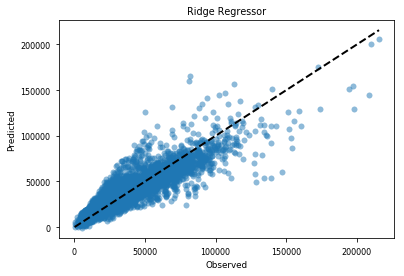

Training model 2/9	ElasticNet


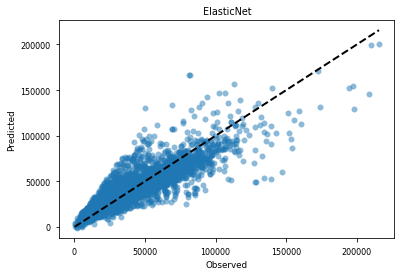

Training model 3/9	Lasso


/usr/local/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


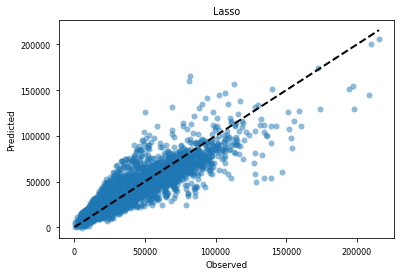

Training model 4/9	AdaBoost Regressor


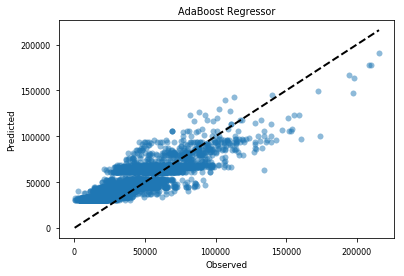

Training model 5/9	Bagging Regressor


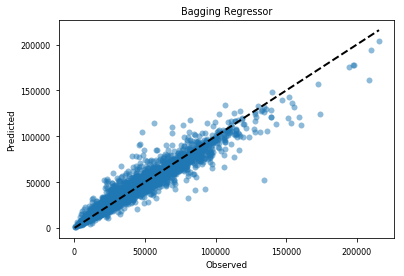

Training model 6/9	Gradient Boosting Regressor, 4_20
      Iter       Train Loss   Remaining Time 
         1   490547343.6015            1.16s
         2   420452780.1444            1.11s
         3   363591186.9118            1.05s
         4   317391779.6275            0.99s
         5   279319700.7861            0.93s
         6   248340984.2032            0.86s
         7   223379545.6255            0.80s
         8   202731041.2462            0.73s
         9   186108301.6004            0.67s
        10   172375707.0560            0.61s
        20   116515001.1293            0.00s


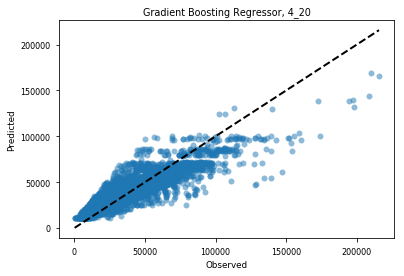

Training model 7/9	Random Forest Regressor


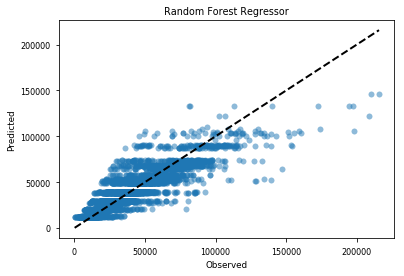

Training model 8/9	Extra Trees Regressor


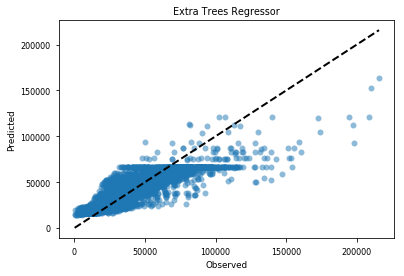

Training model 9/9	MLPRegressor


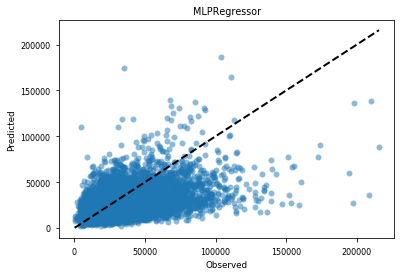

In [19]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.1)

for i in range(len(regressors)):
    regressor = clone(regressors[i])
    regressorName = regressorNames[i]
    
    print("Training model %d/%d\t%s" % (i+1, len(regressors), regressorName))
    
    regressor.fit(X_train,Y_train)
    
    #predict model
    predicted = regressor.predict(X_test)
    predicted[predicted<0] = 0

    #evaluate model
    scores = []
    for l,metric in enumerate(metrics):
        metricName = metricNames[l]
        score = metric(Y_test,predicted)
        scores.append((metricName,score))
    
    predicted = regressor.predict(X)
    plt.figure(1)
    plt.subplot()
    plt.title(regressorName)
    plt.scatter(Y, predicted, alpha = 0.5)
    plt.plot([min(Y), max(Y)], [min(Y), max(Y)], 'k--', lw=2)
    plt.xlabel('Observed')
    plt.ylabel('Predicted')
    plt.show()
    plt.close()


## Feature importances

In [21]:
bestIndex = bestMetricScores.index(min(bestMetricScores))
bestModel = bestRegressorModels[bestIndex]
bestModelName = regressorNames[bestIndex]
print("-"*70)
print("The best model is %s \n"% bestModelName)

featureNames = list(X)
featureImportances = bestModel.coef_
featureRanking = {i:featureImportance for i,featureImportance in enumerate(bestModel.coef_)}
sortedFeatures = sorted(featureRanking, key=featureRanking.get, reverse=True)

print("The top 10 features are ")
print("-"*70)
print("Name\tIndex\tRanking")
topFeatures = []
for featureIndex in sortedFeatures[:10]:
    topFeatures.append(featureImportances[featureIndex])
    print("%s\t%i\t%5.2f"%(featureNames[featureIndex], featureIndex, featureRanking[featureIndex]))

----------------------------------------------------------------------
The best model is ElasticNet 

The top 10 features are 
----------------------------------------------------------------------
Name	Index	Ranking
ELEP	4	303.40
BUS_2	59	282.69
ACR_1	32	281.43
YBL_5	129	264.48
BLD_2	45	224.28
RMSP	12	222.93
BLD_1	44	191.77
BROADBND_1	55	185.85
VEH_3	121	178.61
MODEM_2	80	176.04


## Impute unmatched records

In [23]:
unmatched = pd.read_csv(test_fn)
original_unmatched = pd.read_csv(test_fn)

for i,name in enumerate(column_names):
    if name[-1] != "P" and name != energy:
        unmatched[name] = unmatched[name].astype('category')
    elif name != energy:
        col_mean = unmatched[name].mean()
        col_std = unmatched[name].std()
        unmatched[name] = unmatched[name].astype('float')
#         print name, col_mean, col_std


for featureName in droppedFeatures:
    unmatched = unmatched.drop(featureName,1)

unmatched = pd.get_dummies(unmatched)
newfeatureNames = list(unmatched)

for newfeatureName in newfeatureNames:
    if newfeatureName not in list(X):
        unmatched = unmatched.drop(newfeatureName, 1)

observation, features = unmatched.shape

bestModel.fit(X,Y)
imputed_values = bestModel.predict(unmatched)
imputed_values[imputed_values<0,]=0
original_unmatched[energy]=imputed_values

print("matched y mean: %0.2f, std: %0.2f" %(Y.mean(),Y.std()))
print("imputed y mean: %0.2f, std: %0.2f" %(imputed_values.mean(),imputed_values.std()))
final_output = pd.concat([original_unmatched, original_mateched])
final_output.to_csv(imputed_output_fn, header = True, index = False)

matched y mean: 37625.06, std: 24051.99
imputed y mean: 43744.86, std: 31329.37
